In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'https?://\S+|www\.\S+', '', texto)   # quitar URLs
    texto = re.sub(r'<.*?>', '', texto)                   # quitar HTML
    texto = re.sub(r'[^\w\s]', '', texto)                 # quitar signos de puntuación
    texto = re.sub(r'\d+', '', texto)                     # quitar números
    texto = re.sub(r'\s+', ' ', texto).strip()            # quitar espacios múltiples
    stop_words = set(stopwords.words('english'))          # también puedes combinar con 'spanish'
    palabras = texto.split()
    palabras_filtradas = [w for w in palabras if w not in stop_words]
    return ' '.join(palabras_filtradas)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


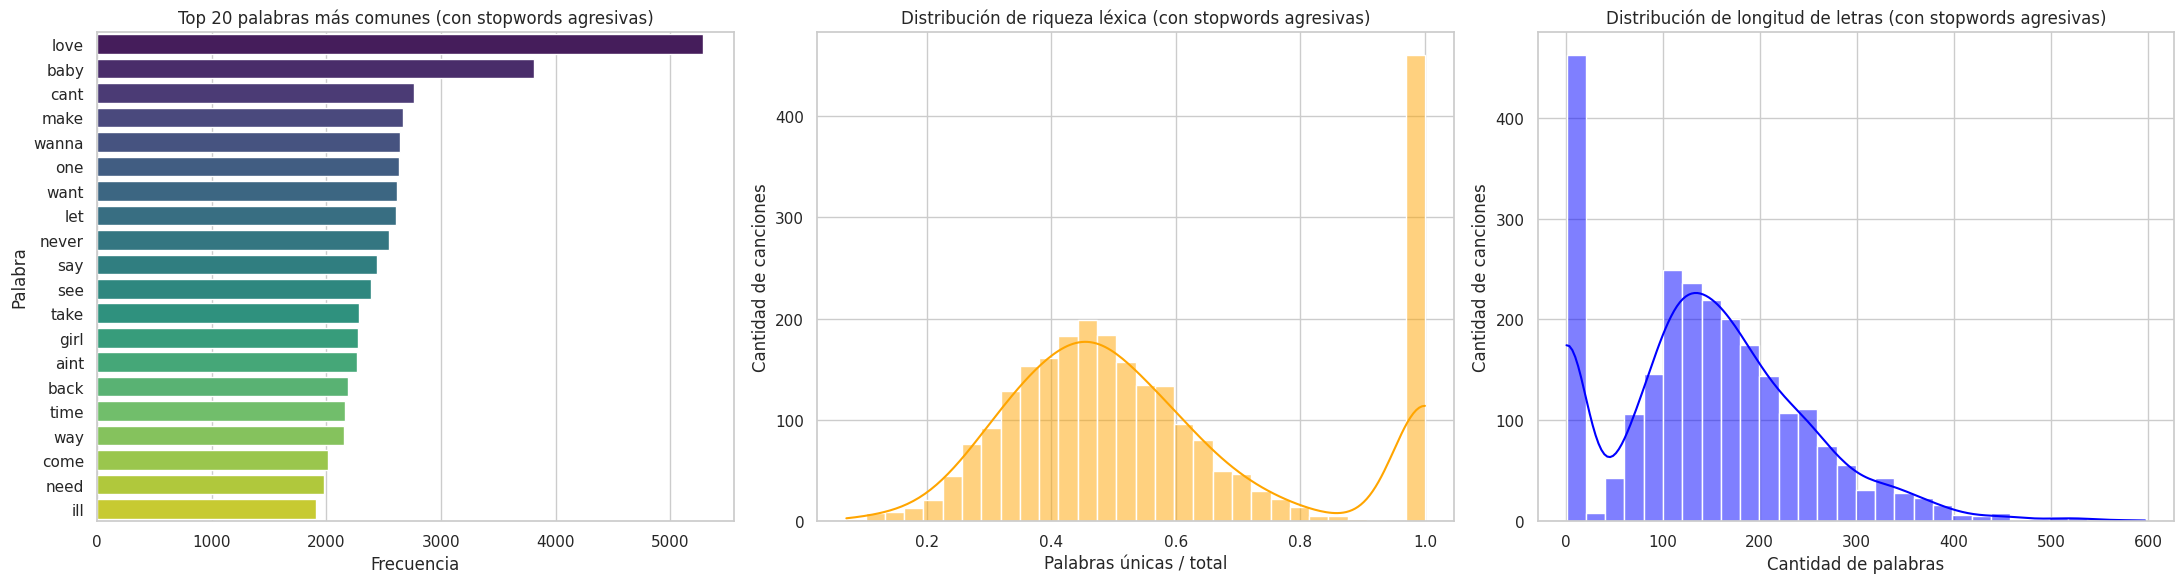

In [ ]:
# 🎶 Punto 1: Lenguaje y Estilo en Letras Musicales

# 📌 IMPORTACIONES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Descargar stopwords (solo la primera vez que ejecutes este script en un entorno nuevo)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Descargando stopwords de NLTK...")
    nltk.download('stopwords')
except LookupError:
     print("Descargando stopwords de NLTK...")
     nltk.download('stopwords')


# 📌 DEFINICIÓN DE FUNCIONES
def limpiar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = texto.lower()
    texto = re.sub(r'https?://\S+|www\.\S+', '', texto)   # quitar URLs
    texto = re.sub(r'<.*?>', '', texto)                   # quitar HTML tags
    # Modificado: Quitar signos de puntuación, números y cualquier cosa que no sea una letra (incluye acentos y ñ) o espacio
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto) # Permite letras de la a-z, acentos, ñ y espacios

    texto = re.sub(r'\s+', ' ', texto).strip()        # quitar espacios múltiples y al inicio/final

    # --- Definición de Stopwords más agresiva y definida ---

    # 1. Stopwords estándar de NLTK (inglés y español)
    stop_words_nltk = set(stopwords.words('english') + stopwords.words('spanish'))

    # 2. Stopwords personalizadas
    # Incluye palabras muy comunes en letras de canciones o texto informal que no son stopwords estándar,
    # así como posibles artefactos de la limpieza.
    custom_stopwords = set([
        'yeah', 'oh', 'ah', 'uh', 'woah', 'hey', 'na', 'da', 'la', # Sonidos comunes / interjecciones
        'got', 'get', 'know', 'dont', 'just', 'cause', 'like', 'im', 'youre', 'thats', ' wanna', 'gonna', # Palabras informales / contracciones / muletillas
        'verse', 'chorus', 'bridge', 'outro', 'intro', 'fade', # Posibles marcadores de sección de letras
        'etc' # Ejemplo genérico de otra palabra a excluir
        # Añade más palabras personalizadas aquí según necesites refinar
    ])

    # Combinar todas las listas de stopwords
    all_stopwords = stop_words_nltk.union(custom_stopwords)

    # --- Aplicar limpieza ---

    palabras = texto.split()

    # 3. Filtrar palabras:
    #    - Que no estén en la lista combinada de stopwords
    #    - Que tengan una longitud mínima (ej: más de 2 caracteres para eliminar palabras muy cortas)
    min_word_length = 2 # Ajusta este valor (ej: > 0 para eliminar solo '', > 1 para eliminar palabras de 1 letra, > 2 para eliminar palabras de 1 o 2 letras)

    palabras_filtradas = [
        w for w in palabras
        if w not in all_stopwords and len(w) > min_word_length
    ]

    return palabras_filtradas  # devuelve lista de tokens (palabras limpias y filtradas)

# 📌 CARGA DE DATOS
df1 = pd.read_csv("letras_com_scrapeadas_corregido.csv")
df2 = pd.read_csv("canciones_con_letras.csv")

# Estandarizamos el nombre de la columna de letras
df1 = df1.rename(columns={"letra": "lyrics"})
df2 = df2.rename(columns={"lyrics": "lyrics"})

# Unificamos columnas relevantes
df1 = df1[["track_name", "artist_name", "lyrics"]]
df2 = df2[["track_name", "artist_name", "lyrics"]]

# Concatenamos los dos datasets
df = pd.concat([df1, df2], ignore_index=True)

# Asegurarse de que la columna 'lyrics' sea tipo string antes de aplicar limpiar_texto
df['lyrics'] = df['lyrics'].astype(str)


# 📌 LIMPIEZA DE TEXTO
df["tokens"] = df["lyrics"].apply(limpiar_texto)

# Manejar casos donde limpiar_texto pueda devolver una lista vacía
df['tokens'] = df['tokens'].apply(lambda x: x if x else []) # Asegura que sea una lista para evitar errores posteriores

# 📌 FRECUENCIA DE PALABRAS MÁS COMUNES
todas_palabras = [palabra for tokens in df["tokens"] for palabra in tokens]
# Modificado: Manejar caso de lista vacía
if todas_palabras:
    frecuencias = Counter(todas_palabras).most_common(20)
    palabras, frecs = zip(*frecuencias)
else:
    frecuencias = [] # Lista vacía si no hay palabras
    palabras, frecs = [], []

# 📌 RIQUEZA LÉXICA (palabras únicas / total)
# Modificado: Calcular riqueza léxica solo si hay tokens
df["riqueza_lexica"] = df["tokens"].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)


# 📌 LONGITUD DE LETRAS
df["longitud"] = df["tokens"].apply(len)

# 📊 VISUALIZACIONES
sns.set(style="whitegrid")
# Modificado: Ajustar el tamaño de la figura si es necesario
fig, axs = plt.subplots(1, 3, figsize=(22, 6)) # Aumentado figsize para mejor visualización

# Gráfico 1: Top palabras
# Modificado: Asegurarse de que haya datos antes de graficar
if frecuencias:
    sns.barplot(x=list(frecs), y=list(palabras), ax=axs[0], palette="viridis")
    axs[0].set_title("Top 20 palabras más comunes (con stopwords agresivas)")
    axs[0].set_xlabel("Frecuencia")
    axs[0].set_ylabel("Palabra")
else:
    axs[0].set_title("No hay palabras para mostrar (después de la limpieza)")
    axs[0].text(0.5, 0.5, "No hay datos", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)


# Gráfico 2: Riqueza léxica
# Modificado: Filtrar valores de riqueza léxica si hay canciones con 0 tokens
sns.histplot(df[df["riqueza_lexica"] > 0]["riqueza_lexica"], bins=30, kde=True, ax=axs[1], color='orange')
axs[1].set_title("Distribución de riqueza léxica (con stopwords agresivas)")
axs[1].set_xlabel("Palabras únicas / total")
axs[1].set_ylabel("Cantidad de canciones")

# Gráfico 3: Longitud de las letras
# Modificado: Filtrar valores de longitud si hay canciones con 0 tokens
sns.histplot(df[df["longitud"] > 0]["longitud"], bins=30, kde=True, ax=axs[2], color='blue')
axs[2].set_title("Distribución de longitud de letras (con stopwords agresivas)")
axs[2].set_xlabel("Cantidad de palabras")
axs[2].set_ylabel("Cantidad de canciones")


plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tópico 1: Rap/Hip-Hop:
 - love, cant, way, say, make, want, think, back, never, time

Tópico 2: Romance/Relaciones:
 - ride, away, pop, stop, baby, want, boom, goes, run, cant

Tópico 3: Upbeat/General (Inglés):
 - aint, rap, girl, hip, hop, back, make, shit, bitch, money

Tópico 4: Español:
 - pop, one, dance, rock, life, night, feel, time, take, right

Tópico 5: Inglés Genérico/Común:
 - love, baby, never, let, ill, one, say, heart, come, pop



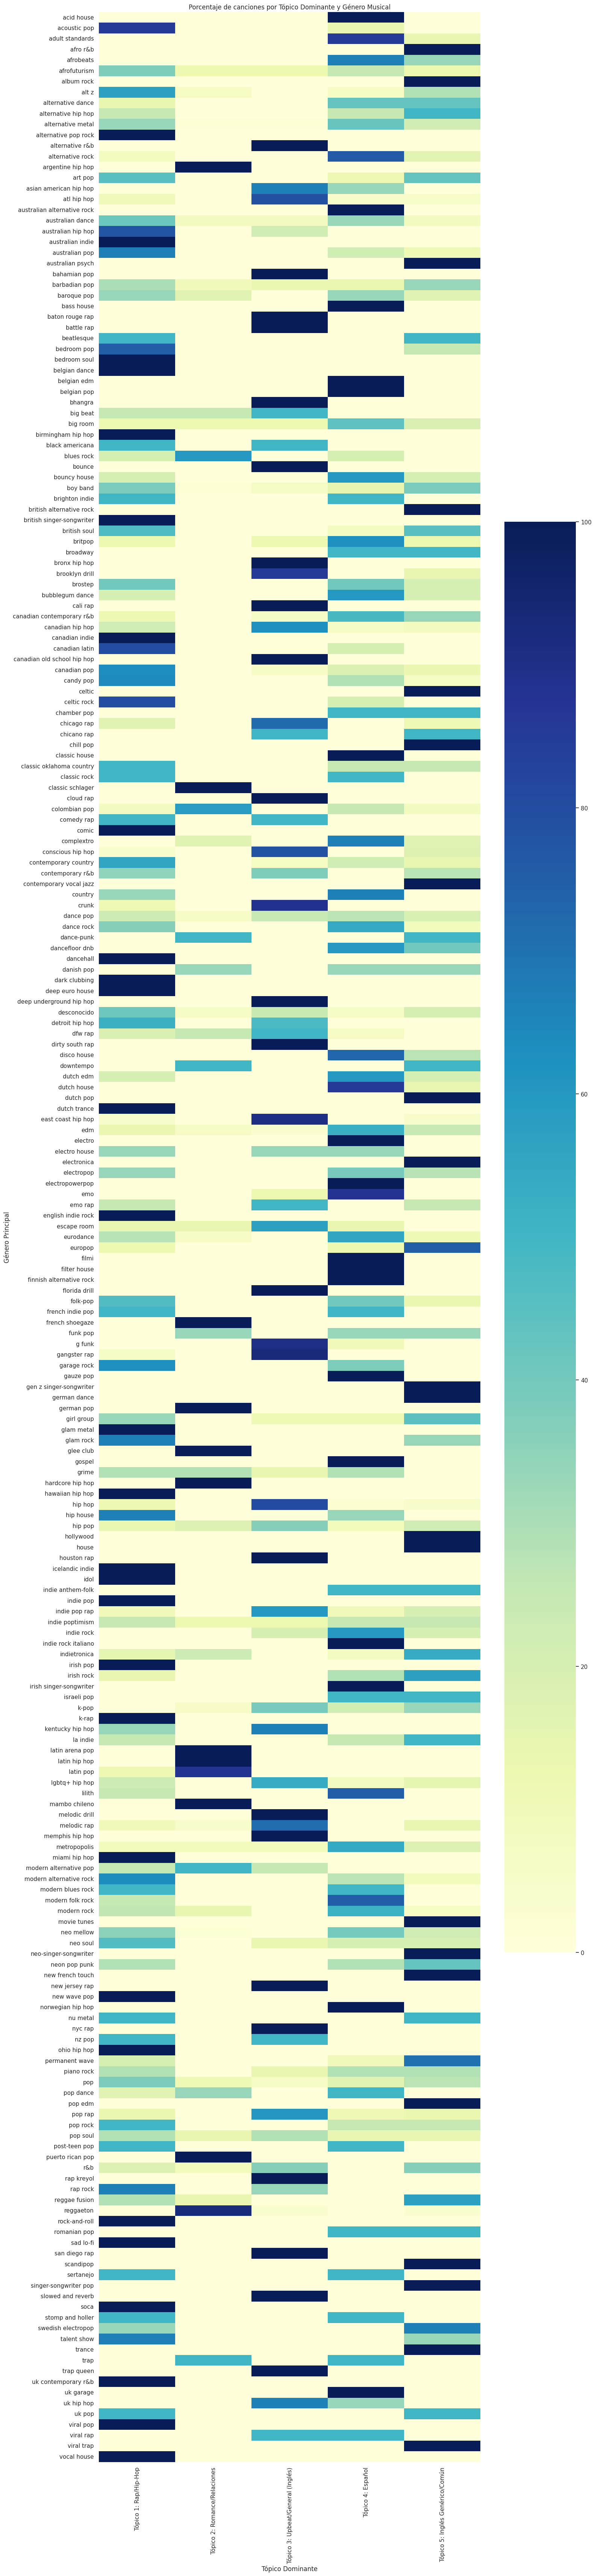

In [ ]:
# 🎵 Punto 2: Relación entre Tópicos Líricos y Géneros Musicales

# --- Código 1: LDA + Análisis de Géneros ---
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')

# --- Limpieza de texto con stopwords agresivos ---
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'https?://\S+|www\.\S+', '', texto)  # URLs
    texto = re.sub(r'<.*?>', '', texto)  # HTML
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)  # Solo letras (incluyendo acentos y ñ)
    texto = re.sub(r'\s+', ' ', texto).strip()  # Espacios múltiples

    # Stopwords estándar (inglés + español)
    stop_words_nltk = set(stopwords.words('english') + stopwords.words('spanish'))

    # Stopwords personalizadas (muletillas, ruidos, marcadores de letras)
    custom_stopwords = set([
        'yeah', 'oh', 'ah', 'uh', 'woah', 'hey', 'na', 'da', 'la',
        'got', 'get', 'know', 'dont', 'just', 'cause', 'like', 'im', 'youre', 'thats', 'wanna', 'gonna',
        'verse', 'chorus', 'bridge', 'outro', 'intro', 'fade', 'repeat',
        'etc', 'ohh', 'laa', 'uhh', 'ayy', 'yea', 'yeh', 'wo', 'hoo'
    ])

    # Combinar todas las listas
    all_stopwords = stop_words_nltk.union(custom_stopwords)

    palabras = texto.split()

    # Filtrar palabras: no stopword, longitud mayor a 2 letras
    palabras_filtradas = [w for w in palabras if w not in all_stopwords and len(w) > 2]

    return ' '.join(palabras_filtradas)

# --- Configuración ---
NOMBRE_ARCHIVO_CSV = 'playlist_con_letras.csv'
COLUMNAS_TEXTO = ['lyrics', 'track_name', 'artist_name', 'artist_genres', 'album']
COLUMNA_TEXTO_COMBINADO = 'texto_completo'
COLUMNA_GENERO_PRINCIPAL = 'genero_principal'
NUM_TOPICOS = 5
NUM_PALABRAS_TOPICO = 10
NOMBRES_TOPICOS = [
    "Tópico 1: Rap/Hip-Hop",
    "Tópico 2: Romance/Relaciones",
    "Tópico 3: Upbeat/General (Inglés)",
    "Tópico 4: Español",
    "Tópico 5: Inglés Genérico/Común"
]

# --- Cargar datos ---
df = pd.read_csv(NOMBRE_ARCHIVO_CSV)
df[COLUMNAS_TEXTO] = df[COLUMNAS_TEXTO].fillna('').astype(str)
df[COLUMNA_TEXTO_COMBINADO] = df[COLUMNAS_TEXTO].agg(' '.join, axis=1)
df[COLUMNA_TEXTO_COMBINADO] = df[COLUMNA_TEXTO_COMBINADO].apply(limpiar_texto)

# --- Vectorizar texto ---
vectorizer = CountVectorizer(max_df=0.9, min_df=10)
dtm = vectorizer.fit_transform(df[COLUMNA_TEXTO_COMBINADO])

# --- Modelo LDA ---
lda = LatentDirichletAllocation(n_components=NUM_TOPICOS, random_state=42)
lda.fit(dtm)

# --- Mostrar palabras clave por tópico ---
def mostrar_topicos(modelo, vectorizador, nombres_topicos, n_palabras=10):
    palabras = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(modelo.components_):
        top_indices = topic.argsort()[:-n_palabras - 1:-1]
        top_palabras = [palabras[i] for i in top_indices]
        print(f"{nombres_topicos[idx]}:")
        print(" - " + ", ".join(top_palabras))
        print()

mostrar_topicos(lda, vectorizer, NOMBRES_TOPICOS, NUM_PALABRAS_TOPICO)

# --- Distribución de tópicos ---
topic_distributions = lda.transform(dtm)
df['topico_dominante_idx'] = topic_distributions.argmax(axis=1)
df['topico_dominante_nombre'] = df['topico_dominante_idx'].apply(lambda x: NOMBRES_TOPICOS[x])

# --- Procesar artist_genres ---
def limpiar_primer_genero(genero_lista_str):
    if pd.isna(genero_lista_str) or genero_lista_str == '[]':
        return 'desconocido'
    try:
        generos = eval(genero_lista_str)
        if isinstance(generos, list) and generos:
            primer = generos[0].strip().lower()
            primer = primer.replace("'", "").replace('"', '').replace('[', '').replace(']', '')
            return primer if primer else 'desconocido'
        else:
            return 'desconocido'
    except (SyntaxError, NameError):
        primer = str(genero_lista_str).split(',')[0].strip().lower()
        primer = primer.replace("'", "").replace('"', '').replace('[', '').replace(']', '')
        return primer if primer else 'desconocido'

df[COLUMNA_GENERO_PRINCIPAL] = df['artist_genres'].apply(limpiar_primer_genero)

# --- Análisis por género ---
temas_por_genero_recuento = df.groupby(COLUMNA_GENERO_PRINCIPAL)['topico_dominante_idx'].value_counts().unstack(fill_value=0)
temas_por_genero_recuento.columns = [NOMBRES_TOPICOS[i] for i in temas_por_genero_recuento.columns]
temas_por_genero_percent = temas_por_genero_recuento.div(temas_por_genero_recuento.sum(axis=1), axis=0) * 100

# --- Mapa de calor ---
plt.figure(figsize=(16, max(8, len(temas_por_genero_percent) * 0.3)))
sns.heatmap(temas_por_genero_percent, annot=False, cmap="YlGnBu")
plt.title("Porcentaje de canciones por Tópico Dominante y Género Musical")
plt.xlabel("Tópico Dominante")
plt.ylabel("Género Principal")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
!pip install pandas matplotlib seaborn


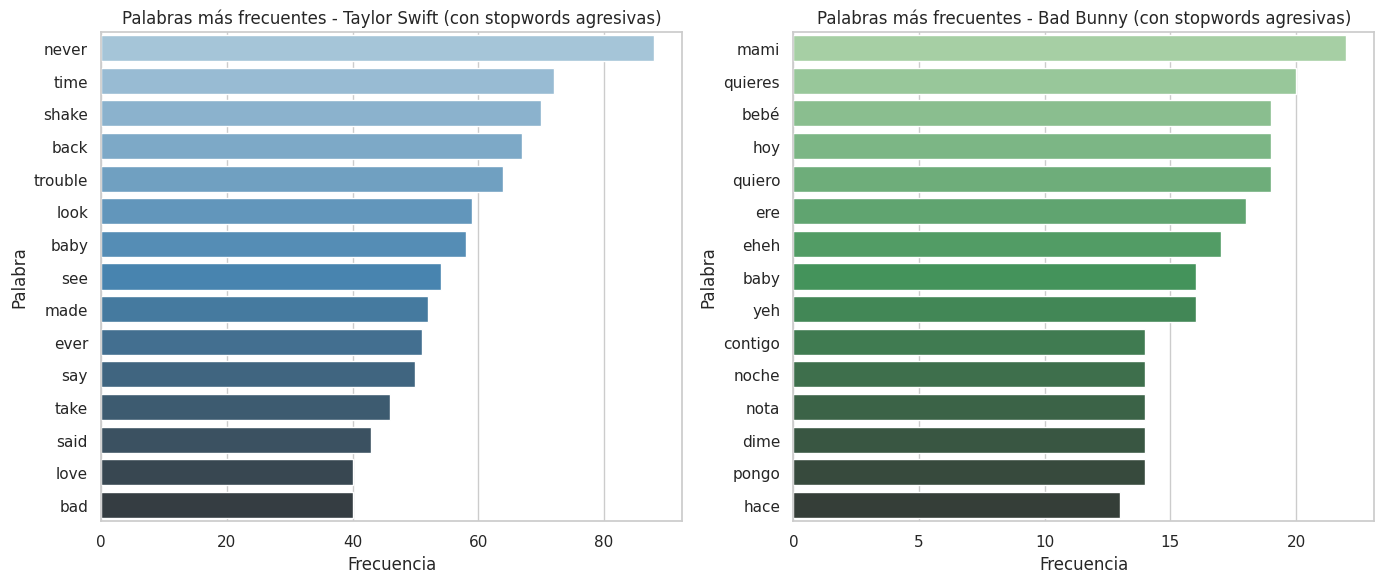

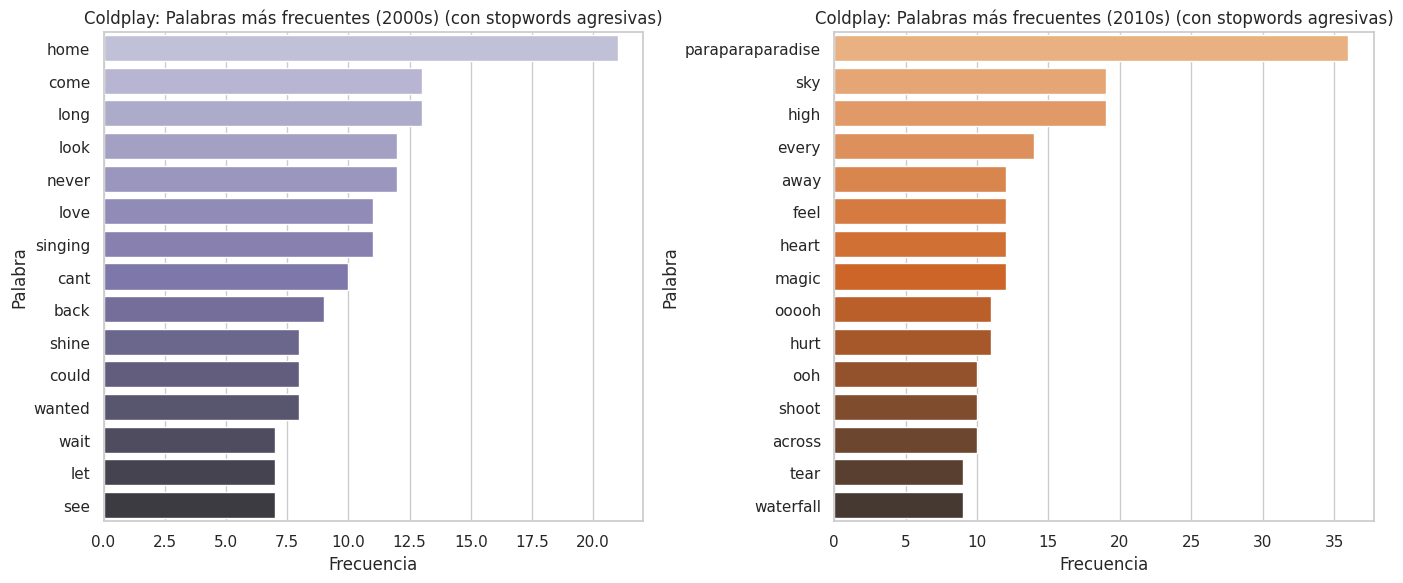


--- Análisis de Similitud entre Artistas Diferentes ---
Canciones seleccionadas para similitud (artistas diferentes):
               artist_name                      track_name
2075                  Lauv                I Like Me Better
1685        Oliver Heldens  Gecko (Overdrive) - Radio Edit
177            Trick Daddy                      I'm a Thug
412               Lil' Kim                     Magic Stick
909                    Unk                     Walk It Out
2385            Noah Cyrus                            July
1600  Florida Georgia Line                          Cruise
556            Katie Melua      The Closest Thing to Crazy
1528             will.i.am                  Scream & Shout
2436        Rauw Alejandro                      Todo De Ti


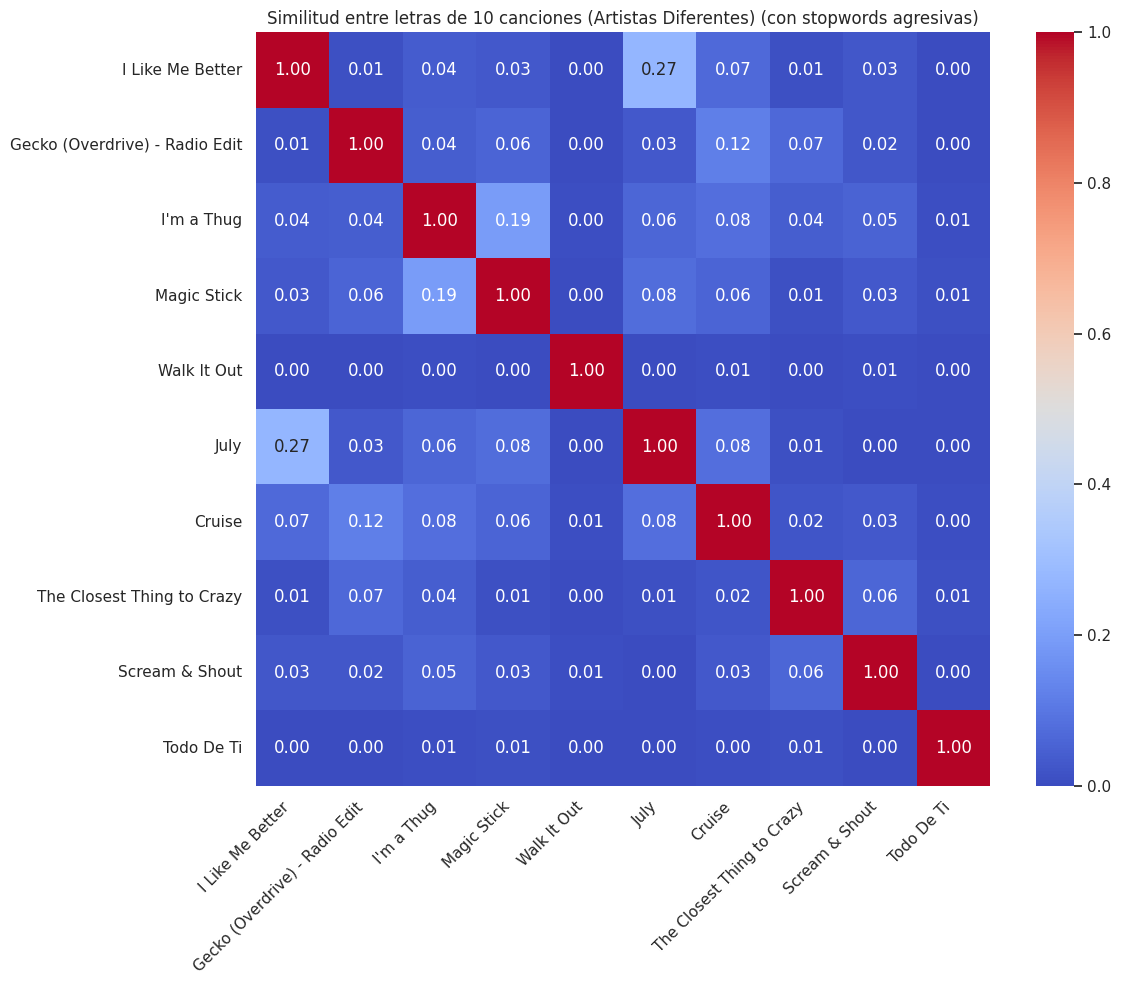


--- Análisis de Similitud en el Género Pop ---
Canciones seleccionadas para similitud (Género Pop - 10 canciones):
      artist_name                                         track_name
0  Olivia Rodrigo                                    drivers license
1        Dua Lipa                                   Hotter Than Hell
2    Taylor Swift                                         Love Story
3      Ed Sheeran                                         The A Team
4   Justin Bieber                                           One Time
5      The Weeknd                                       In Your Eyes
6   Billie Eilish                                              Bored
7   Ariana Grande                                            The Way
8    Harry Styles                                  Sign of the Times
9      The Weeknd  Earned It (Fifty Shades Of Grey) - From The "F...


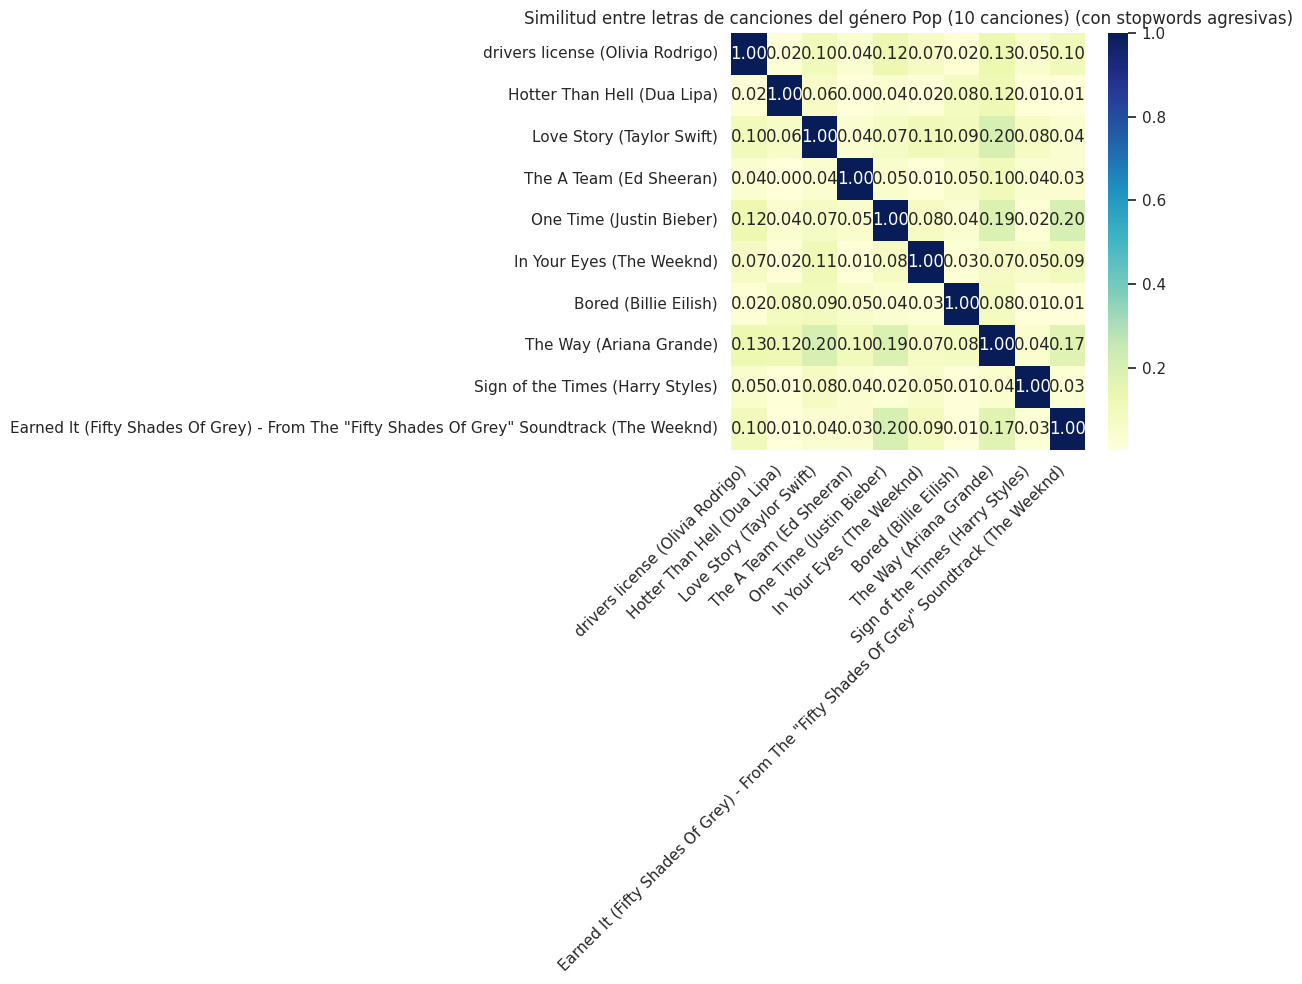


--- Fin de los Análisis ---


In [ ]:
# 🎶 Punto 3: Frecuencia y Similitud en Letras de Canciones

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk
from nltk.corpus import stopwords # Importar stopwords de NLTK
import warnings

warnings.filterwarnings("ignore")

# Descargar stopwords de NLTK (solo la primera vez)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Descargando stopwords de NLTK...")
    nltk.download('stopwords')
except LookupError:
     print("Descargando stopwords de NLTK...")
     nltk.download('stopwords')


# --- Definición de Stopwords más agresiva y definida (Reemplaza las basic_stopwords) ---

# 1. Stopwords estándar de NLTK (inglés y español)
stop_words_nltk = set(stopwords.words('english') + stopwords.words('spanish'))

# 2. Stopwords personalizadas (ejemplos: interjecciones comunes en canciones, palabras cortas genéricas)
custom_stopwords = set([
    'yeah', 'oh', 'ah', 'uh', 'woah', 'hey', 'na', 'da', 'la', # Sonidos comunes / interjecciones
    'got', 'get', 'know', 'dont', 'just', 'cause', 'like', 'im', 'youre', 'thats', ' wanna', 'gonna', # Palabras informales / contracciones / muletillas
    'verse', 'chorus', 'bridge', 'outro', 'intro', 'fade', # Posibles marcadores de sección de letras
    'etc' # Ejemplo genérico de otra palabra a excluir
    # Añade más palabras personalizadas aquí según necesites refinar para tus datos
])

# Combinar todas las listas de stopwords
all_stopwords = stop_words_nltk.union(custom_stopwords)

# Definir longitud mínima de palabra permitida (ajusta este valor)
min_word_length = 2 # Palabras deben tener una longitud > min_word_length (ej: > 2 elimina palabras de 1 o 2 letras)


# Cargar el archivo CSV
df = pd.read_csv("playlist_con_letras.csv")


# --- Función para limpiar letras (Modificada para usar las nuevas stopwords y filtro de longitud) ---
def clean_lyrics(text):
    if pd.isna(text):
        return []
    text = str(text).lower() # Asegurar que es string

    text = re.sub(r'\[.*?\]', '', text) # Eliminar contenido entre corchetes (ej. [Chorus])

    # Modificado: Mantener solo letras (incluyendo acentos y ñ/ü) y espacios
    # Aseguramos que incluye 'ú' y 'ü'
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)

    tokens = text.split()

    # Modificado: Filtrar por la lista combinada de stopwords y la longitud mínima definida
    return [
        word for word in tokens
        if word not in all_stopwords and len(word) > min_word_length
    ]


# --- 1. Análisis de Frecuencia: Artista Angloparlante vs. Hispanohablante ---
# Artistas seleccionados: Taylor Swift (angloparlante) y Bad Bunny (hispanohablante)
artists_to_compare = ['Taylor Swift', 'Bad Bunny']
df_filtered_artists = df[df['artist_name'].isin(artists_to_compare)].copy() # Usar .copy()

words_artist1, words_artist2 = [], []
artist1_name = artists_to_compare[0]
artist2_name = artists_to_compare[1]

if not df_filtered_artists.empty:
    for _, row in df_filtered_artists.iterrows():
        words = clean_lyrics(row['lyrics'])
        if row['artist_name'] == artist1_name:
            words_artist1.extend(words)
        elif row['artist_name'] == artist2_name:
            words_artist2.extend(words)
else:
    print(f"Advertencia: No se encontraron letras para los artistas seleccionados: {artists_to_compare}")


if not words_artist1:
    print(f"Advertencia: Después de la limpieza, no quedaron palabras para {artist1_name}. El gráfico estará vacío o con advertencia.")
if not words_artist2:
    print(f"Advertencia: Después de la limpieza, no quedaron palabras para {artist2_name}. El gráfico estará vacío o con advertencia.")


counter_artist1 = Counter(words_artist1).most_common(15)
counter_artist2 = Counter(words_artist2).most_common(15)

df_artist1 = pd.DataFrame(counter_artist1, columns=['word', 'count'])
df_artist2 = pd.DataFrame(counter_artist2, columns=['word', 'count'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
if not df_artist1.empty:
    sns.barplot(data=df_artist1, y='word', x='count', palette='Blues_d')
    plt.title(f'Palabras más frecuentes - {artist1_name} (con stopwords agresivas)')
else:
    plt.title(f'No hay datos para graficar para {artist1_name}')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.subplot(1, 2, 2)
if not df_artist2.empty:
    sns.barplot(data=df_artist2, y='word', x='count', palette='Greens_d')
    plt.title(f'Palabras más frecuentes - {artist2_name} (con stopwords agresivas)')
else:
    plt.title(f'No hay datos para graficar para {artist2_name}')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.tight_layout()
plt.show()

# --- 2. Análisis de Coldplay por Décadas ---
df_coldplay = df[(df['artist_name'] == 'Coldplay') & df['year'].notna()].copy()
df_coldplay['year'] = pd.to_numeric(df_coldplay['year'], errors='coerce')
df_coldplay.dropna(subset=['year'], inplace=True)
df_coldplay['year'] = df_coldplay['year'].astype(int)


coldplay_2000s = df_coldplay[(df_coldplay['year'] >= 2000) & (df_coldplay['year'] <= 2009)]
coldplay_2010s = df_coldplay[(df_coldplay['year'] >= 2010) & (df_coldplay['year'] <= 2019)]

words_2000s, words_2010s = [], []

if not coldplay_2000s.empty:
    for lyrics in coldplay_2000s['lyrics']:
        words_2000s.extend(clean_lyrics(lyrics))
else:
     print("Advertencia: No se encontraron letras de Coldplay para la década de 2000.")

if not coldplay_2010s.empty:
    for lyrics in coldplay_2010s['lyrics']:
        words_2010s.extend(clean_lyrics(lyrics))
else:
    print("Advertencia: No se encontraron letras de Coldplay para la década de 2010.")


if not words_2000s:
    print("Advertencia: Después de la limpieza, no quedaron palabras para Coldplay 2000s. El gráfico estará vacío o con advertencia.")
if not words_2010s:
    print("Advertencia: Después de la limpieza, no quedaron palabras para Coldplay 2010s. El gráfico estará vacío o con advertencia.")

counter_2000s = Counter(words_2000s).most_common(15)
counter_2010s = Counter(words_2010s).most_common(15)

df_2000s = pd.DataFrame(counter_2000s, columns=['word', 'count'])
df_2010s = pd.DataFrame(counter_2010s, columns=['word', 'count'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
if not df_2000s.empty:
    sns.barplot(data=df_2000s, y='word', x='count', palette='Purples_d')
    plt.title('Coldplay: Palabras más frecuentes (2000s) (con stopwords agresivas)')
else:
    plt.title('Coldplay: No hay datos para graficar para 2000s')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.subplot(1, 2, 2)
if not df_2010s.empty:
    sns.barplot(data=df_2010s, y='word', x='count', palette='Oranges_d')
    plt.title('Coldplay: Palabras más frecuentes (2010s) (con stopwords agresivas)')
else:
    plt.title('Coldplay: No hay datos para graficar para 2010s')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.tight_layout()
plt.show()


# --- 3. Similitud entre letras de 10 canciones (Artistas Diferentes) ---
df_lyrics_present = df[df['lyrics'].notna() & df['artist_name'].notna()].copy()

# Asegurarse de que hay suficientes artistas únicos para tomar una muestra de 10
if df_lyrics_present['artist_name'].nunique() >= 10:
    df_unique_artists = df_lyrics_present.drop_duplicates(subset='artist_name').copy() # Usar .copy()
    sample_df_diverse = df_unique_artists.sample(10, random_state=42).copy() # Usar .copy()

    print("\n--- Análisis de Similitud entre Artistas Diferentes ---")
    print("Canciones seleccionadas para similitud (artistas diferentes):")
    print(sample_df_diverse[['artist_name', 'track_name']])

    # Preprocesar letras usando clean_lyrics y uniendo los tokens en un string
    # clean_lyrics ahora usa las stopwords agresivas y el filtro de longitud
    texts_diverse = [" ".join(clean_lyrics(lyric)) for lyric in sample_df_diverse['lyrics']]

    # Calcular TF-IDF y similitud coseno
    # TfidfVectorizer NO necesita stopwords si ya las quitaste en clean_lyrics
    vectorizer_diverse = TfidfVectorizer()
    tfidf_matrix_diverse = vectorizer_diverse.fit_transform(texts_diverse)

    if tfidf_matrix_diverse.shape[0] > 1 and tfidf_matrix_diverse.shape[1] > 0: # Asegurar que hay al menos 2 documentos con vocabulario
        similarity_matrix_diverse = cosine_similarity(tfidf_matrix_diverse)

        # Crear heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix_diverse, annot=True, fmt=".2f", cmap="coolwarm",
                    xticklabels=sample_df_diverse['track_name'].values,
                    yticklabels=sample_df_diverse['track_name'].values)
        plt.title("Similitud entre letras de 10 canciones (Artistas Diferentes) (con stopwords agresivas)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
         print("Advertencia: No se pudo calcular la matriz TF-IDF para el análisis de similitud de artistas diversos (pocos documentos o vocabulario nulo).")

else:
    print("\nNo hay suficientes artistas únicos (se necesitan al menos 10 con letras) en el dataset para el análisis de similitud de artistas diversos.")


# --- 4. Similitud entre letras (Mismo Género - Nuevo Análisis: Pop) ---
print("\n--- Análisis de Similitud en el Género Pop ---")
# Lista de artistas Pop (ajusta según tu CSV y preferencias)
pop_artists_list = ['Taylor Swift', 'Ed Sheeran', 'Dua Lipa', 'Harry Styles', 'Rosalía', 'The Weeknd', 'Ariana Grande', 'Justin Bieber', 'Billie Eilish', 'Olivia Rodrigo']

# Filtrar canciones de estos artistas Pop que tengan letras
df_pop_artists = df[df['artist_name'].isin(pop_artists_list) & df['lyrics'].notna()].copy() # Usar .copy()

# Seleccionar hasta 10 canciones distintas, idealmente de diferentes artistas Pop si es posible
df_pop_sample = df_pop_artists.drop_duplicates(subset=['artist_name', 'track_name']).copy() # Evitar la misma canción duplicada y usar .copy()

if len(df_pop_sample) > 10:
     # Lógica para muestreo si hay muchas canciones (>10)
     # Priorizamos diversidad de artistas si es posible
    artists_sample = df_pop_sample['artist_name'].drop_duplicates().sample(min(10, df_pop_sample['artist_name'].nunique()), random_state=7).tolist()
    df_pop_sample_diverse_artists = df_pop_sample[df_pop_sample['artist_name'].isin(artists_sample)].groupby('artist_name').head(1).copy() # Tomar una por artista muestreado

    if len(df_pop_sample_diverse_artists) < 10:
        # Si aún no llegamos a 10, completamos con otras canciones pop (podrían ser del mismo artista)
        remaining_needed = 10 - len(df_pop_sample_diverse_artists)
        df_remaining = df_pop_sample[~df_pop_sample.index.isin(df_pop_sample_diverse_artists.index)].sample(min(remaining_needed, len(df_pop_sample) - len(df_pop_sample_diverse_artists)), random_state=7).copy()
        df_pop_sample = pd.concat([df_pop_sample_diverse_artists, df_remaining]).sample(frac=1, random_state=7).reset_index(drop=True) # Combinar y desordenar un poco
    else:
        df_pop_sample = df_pop_sample_diverse_artists.reset_index(drop=True)

elif len(df_pop_sample) >= 2 : # Tenemos entre 2 y 10 canciones, usamos todas
    pass # No se necesita muestreo, ya tenemos el subset correcto
else: # Necesitamos al menos 2 canciones para comparar
     print("No hay suficientes canciones de artistas Pop seleccionados (se necesitan al menos 2) en el dataset para el análisis de similitud de género.")
     # No se ejecuta el resto de este bloque si no hay suficientes datos
     df_pop_sample = pd.DataFrame() # Asegurar que df_pop_sample está definido pero vacío/insuficiente


if 'df_pop_sample' in locals() and len(df_pop_sample) >= 2:
    print(f"Canciones seleccionadas para similitud (Género Pop - {len(df_pop_sample)} canciones):")
    print(df_pop_sample[['artist_name', 'track_name']])

    # Preprocesar letras usando clean_lyrics y uniendo los tokens en un string
    # clean_lyrics ahora usa las stopwords agresivas y el filtro de longitud
    texts_pop = [" ".join(clean_lyrics(lyric)) for lyric in df_pop_sample['lyrics']]

    # Calcular TF-IDF y similitud coseno
    # TfidfVectorizer NO necesita stopwords si ya las quitaste en clean_lyrics
    vectorizer_pop = TfidfVectorizer()
    tfidf_matrix_pop = vectorizer_pop.fit_transform(texts_pop)

    if tfidf_matrix_pop.shape[0] > 1 and tfidf_matrix_pop.shape[1] > 0: # Asegurar que hay al menos 2 documentos con vocabulario
        similarity_matrix_pop = cosine_similarity(tfidf_matrix_pop)

        # Crear heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix_pop, annot=True, fmt=".2f", cmap="YlGnBu",
                    xticklabels=df_pop_sample['track_name'].values + " (" + df_pop_sample['artist_name'].values + ")",
                    yticklabels=df_pop_sample['track_name'].values + " (" + df_pop_sample['artist_name'].values + ")")
        plt.title(f"Similitud entre letras de canciones del género Pop ({len(df_pop_sample)} canciones) (con stopwords agresivas)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
         print("Advertencia: No se pudo calcular la matriz TF-IDF para el análisis de similitud del género Pop (pocos documentos o vocabulario nulo).")

else:
     # Mensaje ya impreso antes si len(df_pop_sample) < 2
     pass


print("\n--- Fin de los Análisis ---")


--- 1. Análisis Histórico: Impacto de la Pandemia (2020-2022) ---
Total de palabras (tokens limpios) analizadas (Pre-Pandemia): 56595
Total de palabras (tokens limpios) analizadas (Durante Pandemia): 48829


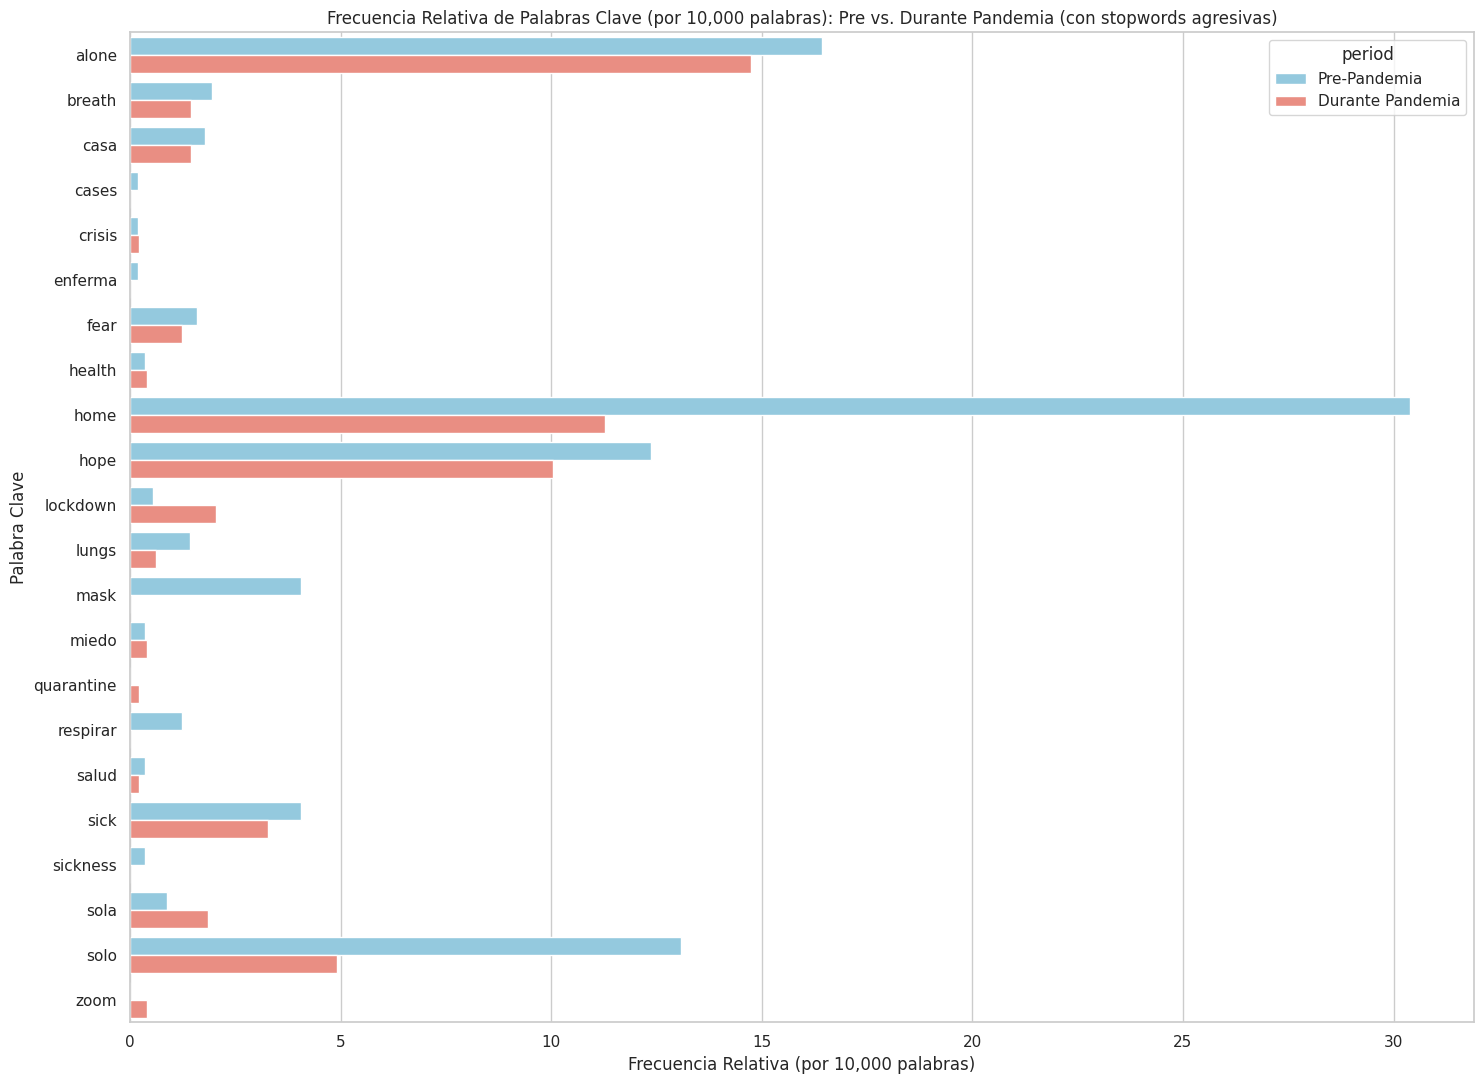


--- 2. Análisis de Palabras y Expresiones de Moda por Década ---
Analizando décadas válidas (con >= 20 canciones): [2000, 2010, 2020]

--- Términos 'De Moda' por Década (basado en frecuencia relativa) ---

Década 2000s:
 - see: 41.91 (por 10k)
 - girl: 41.27 (por 10k)

Década 2010s:
 - take: 38.00 (por 10k)
 - tell: 26.32 (por 10k)

Década 2020s:
 - ooh: 30.50 (por 10k)
 - night: 24.85 (por 10k)

--- 3. Análisis por Grupo Lingüístico ---

--- Términos más frecuentes para el grupo: English-speaking (Total de términos procesados: 73480) ---
  love: 103.16 (por 10k)
  baby: 64.24 (por 10k)
  say: 53.62 (por 10k)
  one: 50.22 (por 10k)
  let: 45.05 (por 10k)
  wanna: 43.28 (por 10k)
  time: 43.14 (por 10k)
  never: 41.51 (por 10k)
  want: 41.10 (por 10k)
  take: 39.74 (por 10k)
  come: 38.11 (por 10k)
  way: 36.88 (por 10k)
  need: 35.79 (por 10k)
  feel: 35.38 (por 10k)
  see: 34.57 (por 10k)
  back: 33.34 (por 10k)
  ooh: 33.34 (por 10k)
  would: 31.85 (por 10k)
  make: 31.03 (por 10k)


In [ ]:
# 🎶 Punto 4: Tendencias y Contexto Social en Letras


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.util import ngrams # Para generar n-gramas (expresiones)
import nltk # Importar nltk
from nltk.corpus import stopwords # Importar stopwords de NLTK
import warnings

warnings.filterwarnings("ignore")

# Descargar stopwords de NLTK (solo la primera vez)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Descargando stopwords de NLTK...")
    nltk.download('stopwords')
except LookupError:
     print("Descargando stopwords de NLTK...")
     nltk.download('stopwords')


# --- Definición de Stopwords más agresiva y definida ---

# 1. Stopwords estándar de NLTK (inglés y español)
stop_words_nltk = set(stopwords.words('english') + stopwords.words('spanish'))

# 2. Stopwords personalizadas (ejemplos: interjecciones comunes en canciones, palabras cortas genéricas)
custom_stopwords = set([
    'yeah', 'oh', 'ah', 'uh', 'woah', 'hey', 'na', 'da', 'la', # Sonidos comunes / interjecciones
    'got', 'get', 'know', 'dont', 'just', 'cause', 'like', 'im', 'youre', 'thats', ' wanna', 'gonna', # Palabras informales / contracciones / muletillas
    'verse', 'chorus', 'bridge', 'outro', 'intro', 'fade', # Posibles marcadores de sección de letras
    'etc' # Ejemplo genérico de otra palabra a excluir
    # Puedes añadir más palabras personalizadas aquí
])

# Combinar todas las listas de stopwords
all_stopwords = stop_words_nltk.union(custom_stopwords)

# Definir longitud mínima de palabra permitida (ajusta este valor)
min_word_length = 2 # Palabras deben tener una longitud > min_word_length (ej: > 2 elimina palabras de 1 o 2 letras)


# --- Cargar el Dataset ---
df = pd.read_csv("playlist_con_letras.csv")

# --- Limpieza de la columna 'year' ---
if 'year' in df.columns:
    # Esta es la línea que causó el error U+00A0
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df.dropna(subset=['year'], inplace=True)
    df['year'] = df['year'].astype(int)
else:
    print("ADVERTENCIA: La columna 'year' no se encuentra. Algunos análisis temporales no se ejecutarán.")
    # Considerar si salir o simplemente omitir partes del código
    # exit()

# --- Funciones de Preprocesamiento y N-gramas (clean_lyrics modificada) ---

# Usar el nuevo set de stopwords combinadas como default
def clean_lyrics(text, custom_stopwords=all_stopwords): # Default es ahora all_stopwords
    if pd.isna(text):
        return []
    text = str(text).lower()

    text = re.sub(r'\[.*?\]', '', text) # Eliminar contenido entre corchetes (ej. [Chorus])

    # Expansión de contracciones
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "i would", text)
    text = re.sub(r"you'd", "you would", text)
    text = re.sub(r"he'd", "he would", text)
    text = re.sub(r"she'd", "she would", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"n't", " not", text)


    # Mantener solo letras (incluyendo acentos y ñ/ü) y espacios
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text) # Ahora incluye 'ú' y 'ü' correctamente

    tokens = text.split()

    # Filtrar por la lista combinada de stopwords (all_stopwords por defecto) y la longitud mínima definida
    return [
        word for word in tokens
        if word not in custom_stopwords and len(word) > min_word_length
    ]

def generate_custom_ngrams(tokens, n_values):
    all_ngrams_list = []
    for n_val in n_values:
        if len(tokens) >= n_val: # Asegurar que hay suficientes tokens para formar n-gramas
            n_grams_iter = ngrams(tokens, n_val)
            all_ngrams_list.extend([" ".join(gram) for gram in n_grams_iter])
    return all_ngrams_list

# --- 1. Análisis Histórico: Impacto de un Evento Social (Ej. Pandemia COVID-19) ---
print("\n--- 1. Análisis Histórico: Impacto de la Pandemia (2020-2022) ---")

if 'year' in df.columns:
    pre_pandemic_years = range(2017, 2020) # Años antes de la pandemia
    during_pandemic_years = range(2020, 2023) # Años durante la pandemia (ejemplo)

    df_pre_pandemic = df[df['year'].isin(pre_pandemic_years)].copy() # Usar .copy()
    df_during_pandemic = df[df['year'].isin(during_pandemic_years)].copy() # Usar .copy()

    # --- Definición de Palabras Clave de la Pandemia ---
    pandemic_keywords_en = {'pandemic', 'covid', 'virus', 'quarantine', 'lockdown', 'mask', 'distancing', 'zoom', 'home', 'isolation', 'health', 'crisis', 'cases', 'vaccine', 'alone', 'fear', 'hope', 'breath', 'lungs', 'sick', 'sickness'}
    pandemic_keywords_es = {'pandemia', 'covid', 'virus', 'cuarentena', 'confinamiento', 'mascarilla', 'distancia', 'zoom', 'casa', 'aislamiento', 'salud', 'crisis', 'casos', 'vacuna', 'solo', 'sola', 'miedo', 'esperanza', 'respirar', 'pulmones', 'enfermo', 'enferma', 'enfermedad'}
    pandemic_keywords = pandemic_keywords_en.union(pandemic_keywords_es) # Combinar keywords

    # --- Calcular stopwords para este análisis ---
    # Empezar con TODAS las stopwords agresivas y quitar las palabras clave de la pandemia
    stopwords_for_pandemic_analysis = all_stopwords - pandemic_keywords


    # --- Función para obtener frecuencias de palabras clave ---
    # Esta función usa clean_lyrics y le pasa la lista de stopwords adecuada (stopwords_for_pandemic_analysis)
    def get_keyword_frequencies(dataframe, keywords_to_track, current_stopwords):
        all_lyrics_tokens = []
        if dataframe.empty:
            return {}, 0 # Devolver vacío si no hay datos

        for lyrics_text in dataframe['lyrics']:
            # Aquí clean_lyrics usa current_stopwords (stopwords_for_pandemic_analysis)
            all_lyrics_tokens.extend(clean_lyrics(lyrics_text, custom_stopwords=current_stopwords))

        word_counts = Counter(all_lyrics_tokens)
        keyword_freq_absolute = {keyword: word_counts.get(keyword, 0) for keyword in keywords_to_track} # Usar .get(keyword, 0) por si la keyword no está en el corpus
        total_words_in_corpus = sum(word_counts.values()) if sum(word_counts.values()) > 0 else 1
        keyword_freq_relative = {kw: (count / total_words_in_corpus) * 10000 for kw, count in keyword_freq_absolute.items()}
        return keyword_freq_relative, total_words_in_corpus

    # Asegurarse de que haya datos suficientes en ambos periodos
    if not df_pre_pandemic.empty and not df_during_pandemic.empty:
        freq_pre, total_words_pre = get_keyword_frequencies(df_pre_pandemic, pandemic_keywords, stopwords_for_pandemic_analysis)
        freq_during, total_words_during = get_keyword_frequencies(df_during_pandemic, pandemic_keywords, stopwords_for_pandemic_analysis)

        print(f"Total de palabras (tokens limpios) analizadas (Pre-Pandemia): {total_words_pre}")
        print(f"Total de palabras (tokens limpios) analizadas (Durante Pandemia): {total_words_during}")

        # Preparar datos para graficar - Usar solo keywords con frecuencia > 0 en al menos un periodo
        plot_data_pandemic = []
        # Incluir solo keywords que tienen frecuencia > 0 en al menos uno de los periodos para graficar
        keywords_to_plot = {kw for kw in pandemic_keywords if freq_pre.get(kw, 0) > 0 or freq_during.get(kw, 0) > 0}
        all_observed_keywords_pandemic = sorted(list(keywords_to_plot))


        for keyword in all_observed_keywords_pandemic:
            plot_data_pandemic.append({'keyword': keyword, 'period': 'Pre-Pandemia', 'frequency': freq_pre.get(keyword, 0)})
            plot_data_pandemic.append({'keyword': keyword, 'period': 'Durante Pandemia', 'frequency': freq_during.get(keyword, 0)})

        df_plot_pandemic = pd.DataFrame(plot_data_pandemic)
        # Considerar filtrar frecuencias bajas para el gráfico, pero la condición > 0.01 podría ser muy estricta si el corpus es pequeño
        # df_plot_pandemic_filtered = df_plot_pandemic[df_plot_pandemic['frequency'] > 0.01] # Mantengo tu filtro original, puedes ajustarlo

        # Asegurarse de que el DataFrame a graficar no está vacío
        if not df_plot_pandemic.empty and not all(df_plot_pandemic['frequency'] == 0):
            plt.figure(figsize=(15, max(8, len(df_plot_pandemic['keyword'].unique()) * 0.5))) # Ajustar tamaño dinámico
            sns.barplot(data=df_plot_pandemic, x='frequency', y='keyword', hue='period', palette={'Pre-Pandemia':'skyblue', 'Durante Pandemia':'salmon'})
            plt.title('Frecuencia Relativa de Palabras Clave (por 10,000 palabras): Pre vs. Durante Pandemia (con stopwords agresivas)')
            plt.xlabel('Frecuencia Relativa (por 10,000 palabras)')
            plt.ylabel('Palabra Clave')
            plt.tight_layout()
            plt.show()
        else:
            print("No se encontraron palabras clave de la pandemia con frecuencia > 0 en los periodos analizados para graficar.")
    else:
        print("No hay suficientes datos en los periodos pre-pandemia o durante la pandemia para realizar el análisis.")
elif 'year' not in df.columns and ('lyrics' in df.columns and 'artist_name' in df.columns):
    print("Columna 'year' no encontrada, saltando análisis temporal de pandemia.")
    pass
else:
    print("El análisis histórico no se puede ejecutar porque falta la columna 'year'.")


# --- 2. Palabras o Expresiones de Moda por Época (Década) ---
# Este análisis usará clean_lyrics con las stopwords por defecto (all_stopwords) y el filtro de longitud
if 'year' in df.columns:
    print("\n--- 2. Análisis de Palabras y Expresiones de Moda por Década ---")

    df_lyrics_dated = df[df['year'].notna()].copy()
    df_lyrics_dated['decade'] = (df_lyrics_dated['year'] // 10) * 10

    min_songs_per_decade = 20
    count_col = 'track_name' if 'track_name' in df_lyrics_dated.columns else df_lyrics_dated.columns[0]
    decade_song_counts = df_lyrics_dated.groupby('decade')[count_col].count()
    valid_decades = decade_song_counts[decade_song_counts >= min_songs_per_decade].index.tolist()

    if not valid_decades:
        print(f"No hay décadas con al menos {min_songs_per_decade} canciones. Ajusta el umbral o revisa tu dataset.")
        pass
    else:
        print(f"Analizando décadas válidas (con >= {min_songs_per_decade} canciones): {sorted(valid_decades)}")
        df_lyrics_dated_filtered = df_lyrics_dated[df_lyrics_dated['decade'].isin(valid_decades)].copy() # Usar .copy()

        top_n_terms_decade = 20 # Número de términos más frecuentes a considerar por década inicialmente
        all_terms_by_decade_rel = {} # Frecuencias relativas de términos por década
        corpus_size_by_decade = {} # Tamaño total del corpus (palabras) por década

        for decade in sorted(df_lyrics_dated_filtered['decade'].unique()):
            df_decade = df_lyrics_dated_filtered[df_lyrics_dated_filtered['decade'] == decade].copy() # Usar .copy()
            if df_decade.empty: continue

            all_tokens_decade_processed = []
            for lyrics_text in df_decade['lyrics']:
                # clean_lyrics usa las stopwords por defecto (all_stopwords)
                cleaned_tokens = clean_lyrics(lyrics_text)
                all_tokens_decade_processed.extend(cleaned_tokens)
                if len(cleaned_tokens) >= 2: # Solo si hay suficientes tokens para 2-gramas
                    # Generar 2-gramas a partir de los tokens ya limpiados
                    all_tokens_decade_processed.extend(generate_custom_ngrams(cleaned_tokens, [2]))

            if not all_tokens_decade_processed:
                corpus_size_by_decade[decade] = 0
                all_terms_by_decade_rel[decade] = [] # Lista vacía si no hay términos
                continue

            term_counts_decade_abs = Counter(all_tokens_decade_processed)
            total_terms_in_decade = sum(term_counts_decade_abs.values())
            corpus_size_by_decade[decade] = total_terms_in_decade

            if total_terms_in_decade == 0: # Doble verificación
                all_terms_by_decade_rel[decade] = []
                continue

            # Calcular frecuencia relativa por 10,000 palabras/términos
            terms_rel_freq = [(term, (count / total_terms_in_decade) * 10000) for term, count in term_counts_decade_abs.most_common(top_n_terms_decade * 2)] # Considerar más términos inicialmente
            all_terms_by_decade_rel[decade] = sorted(terms_rel_freq, key=lambda x: x[1], reverse=True)[:top_n_terms_decade] # Quedarse con el top N

        # --- Identificar términos de moda ---
        all_top_terms_set = set() # Conjunto de todos los términos top encontrados en cualquier década
        for decade_val in sorted(all_terms_by_decade_rel.keys()):
            if all_terms_by_decade_rel[decade_val]:
                for term, freq in all_terms_by_decade_rel[decade_val]: all_top_terms_set.add(term)

        term_trends = [] # Para almacenar la frecuencia de cada término top en cada década
        if all_terms_by_decade_rel:
            for term in sorted(list(all_top_terms_set)): # Ordenar términos alfabéticamente
                for decade_val in sorted(all_terms_by_decade_rel.keys()): # Ordenar décadas
                    freq_in_decade = 0
                    if all_terms_by_decade_rel[decade_val]:
                        # Buscar la frecuencia del término en la lista top de esta década
                        freq_in_decade = next((f for t, f in all_terms_by_decade_rel[decade_val] if t == term), 0)
                    term_trends.append({'term': term, 'decade': decade_val, 'relative_frequency': freq_in_decade})

        df_term_trends = pd.DataFrame(term_trends) # DataFrame con tendencias por década

        # Identificar términos "de moda" (significativamente más frecuentes en una década que en otras)
        fashionable_terms_output = {}
        min_relative_freq_for_fashionable = 0.5 # Umbral mínimo de frecuencia para considerar un término (ajusta)
        distinctiveness_ratio = 2.5 # Cuántas veces más frecuente debe ser en la década foco vs. el promedio de otras décadas (ajusta este valor)
        if all_terms_by_decade_rel:
            for decade_focus in sorted(all_terms_by_decade_rel.keys()):
                fashionable_terms_output[decade_focus] = []
                other_decades = [d for d in all_terms_by_decade_rel.keys() if d != decade_focus]

                if all_terms_by_decade_rel[decade_focus]:
                    # Solo consideramos los top terms de la década foco como candidatos a "de moda"
                    for term, current_freq in all_terms_by_decade_rel[decade_focus]:
                        if current_freq < min_relative_freq_for_fashionable: continue # Debe tener una frecuencia mínima en la década foco

                        freq_in_other_decades = []
                        if other_decades:
                            for od in other_decades:
                                if all_terms_by_decade_rel[od]: # Asegurar que la década tiene datos
                                    # Buscar la frecuencia del término en la lista top de otras décadas
                                    freq_in_other_decades.append(next((f for t, f in all_terms_by_decade_rel[od] if t == term), 0) )

                        # Calcular frecuencia promedio en otras décadas (evitar división por cero)
                        # Añadir una pequeña constante (ej. 0.001) al divisor para evitar división por cero real si todas las frecuencias en otras décadas son 0
                        avg_freq_others = sum(freq_in_other_decades) / len(freq_in_other_decades) if freq_in_other_decades else 0
                        divisor = avg_freq_others + 0.001


                        # Criterio para ser "de moda": significativamente más frecuente en la década foco que en el promedio de las otras
                        if current_freq / divisor > distinctiveness_ratio:
                            fashionable_terms_output[decade_focus].append((term, current_freq))

                # Ordenar los términos de moda encontrados por frecuencia descendente
                fashionable_terms_output[decade_focus] = sorted(fashionable_terms_output[decade_focus], key=lambda x: x[1], reverse=True)


            # --- Imprimir resultados de términos de moda por década ---
            print("\n--- Términos 'De Moda' por Década (basado en frecuencia relativa) ---")
            if fashionable_terms_output:
                for decade_val in sorted(fashionable_terms_output.keys()):
                    print(f"\nDécada {decade_val}s:")
                    if fashionable_terms_output[decade_val]:
                        for term, freq_rel in fashionable_terms_output[decade_val]:
                            print(f" - {term}: {freq_rel:.2f} (por 10k)")
                    else:
                        print("  No se identificaron términos 'de moda' significativos en esta década con los umbrales actuales.")
            else:
                 print("\nNo se generaron datos de tendencias de términos por década (asegúrate de que haya al menos dos décadas válidas y términos frecuentes).")


elif 'lyrics' in df.columns and 'artist_name' in df.columns:
    # print("Columna 'year' no encontrada, saltando análisis de moda por década.") # Opcional
    pass
# else: # OMITIDO: ya hay un print de advertencia al inicio si 'year' no existe


# --- 3. Análisis por Grupo Lingüístico (Hispanohablantes vs. Angloparlantes) ---
# Este análisis usará clean_lyrics con las stopwords por defecto (all_stopwords) y el filtro de longitud
print("\n--- 3. Análisis por Grupo Lingüístico ---")

# !!! ACCIÓN REQUERIDA POR EL USUARIO: Poblar estas listas con artistas de tu dataset !!!
# Mantengo tus ejemplos, pero asegúrate de que coinciden con los nombres en tu CSV
hispanic_artists_example = {
    'Bad Bunny', 'Rosalía', 'J Balvin', 'Shakira', 'Daddy Yankee', 'Karol G',
    'Ozuna', 'Maluma', 'Enrique Iglesias', 'Luis Fonsi', 'Nathy Peluso', 'C. Tangana',
}
english_speaking_artists_example = {
    'Taylor Swift', 'Ed Sheeran', 'Drake', 'Ariana Grande', 'The Weeknd', 'Billie Eilish',
    'Justin Bieber', 'Dua Lipa', 'Post Malone', 'Adele', 'Beyoncé', 'Rihanna',
}
# !!! FIN DE ACCIÓN REQUERIDA POR EL USUARIO !!!

def assign_language_group(artist_name_series_value):
    if pd.isna(artist_name_series_value):
        return 'Other/Unknown'
    name_str = str(artist_name_series_value).strip() # Limpiar espacios

    if name_str in hispanic_artists_example:
        return 'Hispanic'
    elif name_str in english_speaking_artists_example:
        return 'English-speaking'
    else:
        return 'Other/Unknown'

if 'artist_name' in df.columns and 'lyrics' in df.columns:
    df['language_group'] = df['artist_name'].apply(assign_language_group)
    # Filtrar solo los grupos que nos interesan para el análisis comparativo
    df_linguistic = df[df['language_group'].isin(['Hispanic', 'English-speaking'])].copy() # Usar .copy()

    if df_linguistic.empty or len(df_linguistic['language_group'].unique()) < 2:
        print("\nNo hay suficientes datos o diversidad de grupos lingüísticos ('Hispanic', 'English-speaking') definidos para el análisis.")
        print("Por favor, revisa y expande las listas 'hispanic_artists_example' y 'english_speaking_artists_example' con artistas de tu dataset.")
        # Imprimir info para depuración
        print(f"Artistas únicos en el dataset: {df['artist_name'].nunique()}")
        print(f"Recuento de canciones por grupo lingüístico asignado: {df['language_group'].value_counts().to_dict()}") # Mostrar cuántas canciones se asignaron a cada grupo
    else:
        top_n_terms_lang = 25 # Número de términos más frecuentes a mostrar por grupo
        all_terms_by_lang_group_rel = {} # Frecuencias relativas de términos por grupo
        corpus_size_by_lang_group = {} # Tamaño total del corpus por grupo

        for lang_group in sorted(df_linguistic['language_group'].unique()):
            df_group = df_linguistic[df_linguistic['language_group'] == lang_group].copy() # Usar .copy()
            if df_group.empty: # Doble verificación, no debería ocurrir si el filtro inicial funciona
                print(f"No hay canciones para el grupo lingüístico: {lang_group} después del filtrado inicial.")
                continue

            all_tokens_group_processed = []
            for lyrics_text in df_group['lyrics']:
                # clean_lyrics usa las stopwords por defecto (all_stopwords)
                cleaned_tokens = clean_lyrics(lyrics_text)
                all_tokens_group_processed.extend(cleaned_tokens)
                if len(cleaned_tokens) >= 2: # Solo si hay suficientes tokens para 2-gramas
                    # Generar 2-gramas
                    all_tokens_group_processed.extend(generate_custom_ngrams(cleaned_tokens, [2]))

            if not all_tokens_group_processed:
                print(f"No se extrajeron términos para el grupo lingüístico: {lang_group}")
                corpus_size_by_lang_group[lang_group] = 0
                all_terms_by_lang_group_rel[lang_group] = [] # Lista vacía si no hay términos
                continue

            term_counts_group_abs = Counter(all_tokens_group_processed)
            total_terms_in_group = sum(term_counts_group_abs.values())
            corpus_size_by_lang_group[lang_group] = total_terms_in_group

            if total_terms_in_group == 0: # Doble verificación
                all_terms_by_lang_group_rel[lang_group] = []
                continue


            # Calcular frecuencia relativa por 10,000 palabras/términos
            terms_rel_freq = [
                (term, (count / total_terms_in_group) * 10000)
                for term, count in term_counts_group_abs.most_common(top_n_terms_lang * 2) # Considerar más términos inicialmente
            ]
            all_terms_by_lang_group_rel[lang_group] = sorted(terms_rel_freq, key=lambda x: x[1], reverse=True)[:top_n_terms_lang] # Quedarse con el top N


            # Imprimir los términos más frecuentes por grupo lingüístico
            print(f"\n--- Términos más frecuentes para el grupo: {lang_group} (Total de términos procesados: {total_terms_in_group}) ---")
            if not all_terms_by_lang_group_rel[lang_group]:
                print("  No hay términos frecuentes para mostrar.")
            for term, freq_rel in all_terms_by_lang_group_rel[lang_group]:
                print(f"  {term}: {freq_rel:.2f} (por 10k)")

        # --- Identificar términos distintivos ---
        print("\n--- Términos Distintivos por Grupo Lingüístico ---")
        # Asegurarse de que tenemos datos para ambos grupos antes de comparar
        if 'Hispanic' in all_terms_by_lang_group_rel and 'English-speaking' in all_terms_by_lang_group_rel:
            terms_hispanic_dict = dict(all_terms_by_lang_group_rel.get('Hispanic', []))
            terms_english_dict = dict(all_terms_by_lang_group_rel.get('English-speaking', []))

            # Umbrales para considerar un término distintivo (ajusta estos valores)
            min_freq_threshold = 0.5 # Frecuencia relativa mínima en el grupo foco (ajusta)
            distinctiveness_ratio = 2.5 # Cuántas veces más frecuente debe ser en el grupo foco vs. el otro grupo (ajusta)

            distinctive_hispanic = [] # Términos más frecuentes en 'Hispanic' que en 'English-speaking'
            for term, freq_h in terms_hispanic_dict.items():
                if freq_h < min_freq_threshold: continue # Cumplir umbral mínimo en el grupo foco
                freq_e = terms_english_dict.get(term, 0) # Frecuencia en el otro grupo (0 si no está en el top)
                # Criterio de distinción: mucho más frecuente en 'Hispanic'
                # Añadir 0.01 al divisor para evitar división por cero si freq_e es muy pequeña
                if freq_e == 0 or freq_h / (freq_e + 0.01) > distinctiveness_ratio :
                    distinctive_hispanic.append((term, freq_h, freq_e))

            distinctive_english = [] # Términos más frecuentes en 'English-speaking' que en 'Hispanic'
            for term, freq_e in terms_english_dict.items():
                if freq_e < min_freq_threshold: continue # Cumplir umbral mínimo en el grupo foco
                freq_h = terms_hispanic_dict.get(term, 0) # Frecuencia en el otro grupo
                # Criterio de distinción: mucho más frecuente en 'English-speaking'
                # Añadir 0.01 al divisor para evitar división por cero
                if freq_h == 0 or freq_e / (freq_h + 0.01) > distinctiveness_ratio:
                    distinctive_english.append((term, freq_e, freq_h))


            # Imprimir resultados
            print("\nDistintivos para el grupo 'Hispanic' (Frec. Relativa en Hispano / Frec. Relativa en Inglés):")
            # Mostrar los top 15 distintivos ordenados por frecuencia en el grupo foco
            for term, freq_h, freq_e in sorted(distinctive_hispanic, key=lambda x: x[1], reverse=True)[:15]:
                print(f"  {term}: {freq_h:.2f} / {freq_e:.2f}")

            print("\nDistintivos para el grupo 'English-speaking' (Frec. Relativa en Inglés / Frec. Relativa en Hispano):")
            # Mostrar los top 15 distintivos ordenados por frecuencia en el grupo foco
            for term, freq_e, freq_h in sorted(distinctive_english, key=lambda x: x[1], reverse=True)[:15]:
                print(f"  {term}: {freq_e:.2f} / {freq_h:.2f}")

        else:
            print("No se pudieron calcular términos distintivos (faltan datos de uno o ambos grupos lingüísticos).")
            print("Asegúrate de que las listas de artistas 'hispanic_artists_example' y 'english_speaking_artists_example' están bien pobladas con artistas que realmente tienen letras en tu dataset.")
            # Ayuda de depuración: verificar si se asignaron canciones a los grupos
            print(f"Recuento de canciones por grupo lingüístico en df_linguistic: {df_linguistic['language_group'].value_counts().to_dict()}")


else:
    print("Las columnas 'artist_name' y 'lyrics' son necesarias para el análisis por grupo lingüístico y una o ambas no se encontraron.")


print("\n--- Fin de los Análisis ---")